In [0]:
! pip install git+https://github.com/fastai/fastai_dev

In [0]:
from fastai.text import *

In [0]:
from fastai.callbacks import Hooks

In [0]:
import os 

In [0]:
import warnings

In [0]:
warnings.filterwarnings("ignore")


In [0]:
bs=48
path = untar_data(URLs.IMDB)
path.ls()





[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

In [0]:
path

PosixPath('/root/.fastai/data/imdb')

In [0]:

data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


In [0]:
learn_lm.save_encoder('fine_tuned_enc')


In [0]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
from fastai.callbacks import HookCallback
from torch.nn import LSTM

In [0]:
class  Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

class Hooks():
    "Create several hooks on the modules in `ms` with `hook_func`."
    def __init__(self, ms:Collection[nn.Module], hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int)->Hook: return self.hooks[i]
    def __len__(self)->int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        "Remove the hooks from the model."
        for h in self.hooks: h.remove()

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()


In [0]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m, hook_func, is_forward=True, detach=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module, input, output):
        "Applies `hook_func` to `module`, `input`, `output`."
        import pdb;pdb.set_trace()
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()

        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()


class Hooks():
    "Create several hooks on the modules in `ms` with `hook_func`."
    def __init__(self, ms, hook_func, is_forward=True, detach=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int)->Hook: return self.hooks[i]
    def __len__(self)->int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        "Remove the hooks from the model."
        for h in self.hooks: h.remove()

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()


In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, torch.nn.LSTM)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()


class ActivationStats_LSTM(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m, i, o):
        "Take the mean and std of `o`."
        import pdb;pdb.set_trace()
        return o[1][0].mean().item(),o[1][0].std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:tuple, o:tuple)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

In [0]:
gc.collect()

133

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,callback_fns=ActivationStats_LSTM)


In [0]:
mean = []
std = []
def hook(m, i, o):
    "Take the mean and std of `o`."
    mean.append(o[1][0].mean().item())
    std.append(o[1][0].std().item())


In [0]:
learn = learn.load_encoder('fine_tuned_enc')


In [0]:
modules = [m for m in flatten_model(learn.model)
                            if isinstance(m, torch.nn.LSTM)]


In [0]:
modules[0].register_forward_hook(hook)

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
len(mean)

0

In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

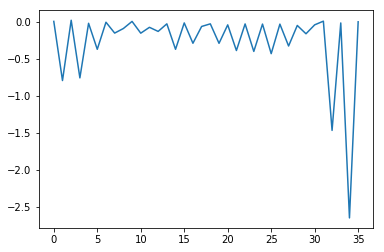

In [0]:
plt.plot(means)

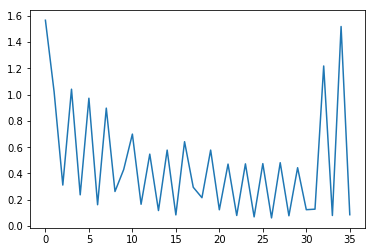

In [0]:
plt.plot(stds)

In [0]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

In [0]:
mods[0].num_layers

1

In [0]:

def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.to(torch.device('cuda'))


In [0]:
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

In [0]:
xb,yb = data_clas.one_batch()

In [0]:
data_clas.train_dl.x.to(torch.device('cuda'))

AttributeError: ignored

In [0]:
for hook in hooks: print(hook.mean,hook.std)

In [0]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

In [0]:
mdl

In [0]:
>>> rnn = nn.LSTM(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)

In [0]:
rnn.register_forward_hook(hook)


In [0]:
>>> output, (hn, cn) = rnn(input, (h0, c0))


> <ipython-input-114-90662714e63a>(4)hook()
-> return o.mean().item(),o.std().item()
(Pdb) o 
(tensor([[[-2.5948e-01, -8.9714e-02, -3.8792e-01, -1.2304e-01, -2.9241e-01,
          -4.2353e-01, -5.5217e-02,  2.7919e-01,  5.0661e-01,  7.4136e-02,
           3.4006e-02, -3.3203e-02, -7.0854e-02,  2.9344e-01,  1.4524e-01,
          -5.5786e-01,  8.9902e-02,  3.1441e-02,  6.4520e-02, -1.6160e-01],
         [-3.2259e-01,  9.8162e-02, -3.0071e-01,  1.1216e-01, -1.7026e-01,
           1.1765e-01,  1.2366e-01, -2.1583e-01, -5.0714e-01,  5.6318e-01,
           1.7843e-01,  1.4180e-01, -1.9182e-01, -6.0614e-04, -1.7267e-01,
          -5.3232e-01,  1.8171e-02,  3.6531e-01, -1.7608e-01, -5.5089e-01],
         [ 3.3725e-02,  3.2056e-01,  6.3262e-01, -1.3860e-02, -3.8328e-01,
          -2.0100e-01, -2.2671e-01,  2.6368e-01,  3.9997e-02,  1.7674e-01,
          -1.4727e-01,  5.0521e-02, -4.0556e-01,  4.1815e-02,  2.0404e-01,
          -1.7777e-01, -2.4711e-01,  9.4845e-02, -5.0206e-01, -1.8404e-01]],



BdbQuit: ignored

Testing Out Activation Stats With Vision. 



In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import Hooks

In [0]:
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart


In [0]:
path = untar_data(URLs.PETS); path


PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)


In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

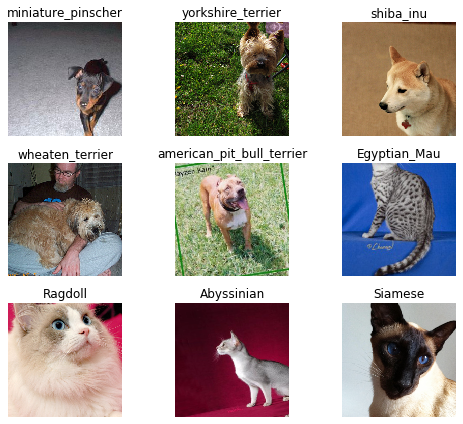

In [0]:
data.show_batch(rows=3, figsize=(7,6))


In [0]:
from fastai.callbacks import ActivationStats

In [0]:
from torch.nn import Conv2d

In [0]:
import collections

def requires_grad_counter(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return collections.Counter([it.requires_grad for it in ps])


def requires_grad_bool(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return ps[0].requires_grad

In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, Conv2d)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()

class ActivationStats(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=ActivationStats)


In [0]:
def has_params(m:nn.Module)->bool:
    "Check if `m` has at least one parameter"
    return len(list(m.parameters())) > 0


In [0]:
modules = [m for m in flatten_model(learn.model) if has_params(m)]

In [0]:
for it in modules:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 

In [0]:
learn.freeze_to(-2)


In [0]:
modules = [m for m in flatten_model(learn.model) if has_params(m)]
for it in modules:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
 mods = [m for m in flatten_model(learn.model)
                            if isinstance(m, Conv2d)]

In [0]:
for it in mods:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Counter({False: 1}) Conv2d(128, 1

In [0]:
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

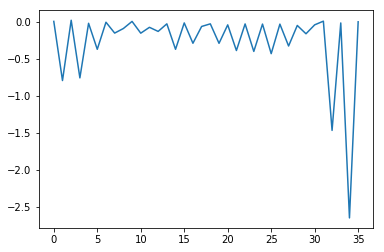

In [0]:
plt.plot(means)

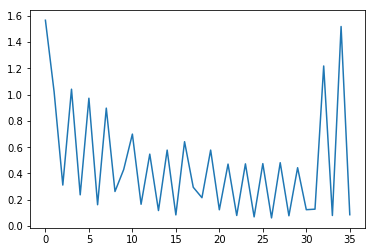

In [0]:
plt.plot(stds)

In [0]:
learn.freeze_to(-2)

In [0]:
modules = [m for m in flatten_model(learn.model) if has_params(m)]

In [0]:
for it in modules:
  print(requires_grad_bool(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({True: 2}) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Counter({False: 

In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, Conv2d) and requires_grad_bool(m)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()

    
class ActivationStats(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack,ActivationStats])
learn.freeze_to(-2)
learn.fit_one_cycle(1)


0
0.5466501712799072
1.0000001192092896
1
0.45240989327430725
1.0
2
0.1861620843410492
1.0
3
1.682502031326294
0.9999998807907104
4
0.25763624906539917
1.0
5
1.392309308052063
1.0
6
0.18646807968616486
1.0000001192092896
7
2.1369950771331787
1.0000001192092896
8
0.22551433742046356
1.0000001192092896
9
1.3533962965011597
1.0
10
0.2819548547267914
1.0
11
4.416240215301514
0.9999998807907104
12
0.44856441020965576
1.0000001192092896
13
2.4459688663482666
0.9999999403953552
14
0.42530372738838196
1.0
15
1.1097501516342163
0.9999999403953552
16
7.312355041503906
0.9999999403953552
17
0.11392895877361298
1.0
18
15.058943748474121
0.9999998807907104
19
0.03630141541361809
1.0


epoch,train_loss,valid_loss,error_rate,time
0,1.057578,0.493699,0.147497,01:59


In [0]:
 mods = [m for m in flatten_model(learn.model)
                            if isinstance(m, Conv2d)]

In [0]:
for it in mods:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Counter({False: 1}) Conv2d(128, 1

In [0]:
learn.freeze_to(-2)


In [0]:
 mods = [m for m in flatten_model(learn.model) if isinstance(m, Conv2d)]

In [0]:
for it in mods:
  print(requires_grad_counter(it),it)

Counter({False: 1}) Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Counter({False: 1}) Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Counter({False: 1}) Conv2d(128, 1

In [0]:
len(learn.activation_stats.modules)

20

In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(20)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(20)]

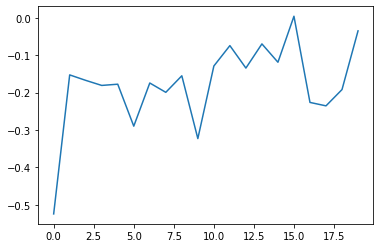

In [0]:
plt.plot(means)

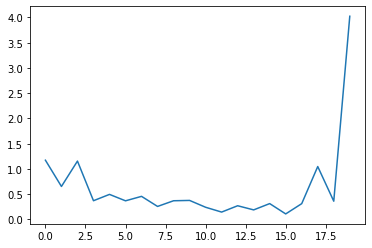

In [0]:
plt.plot(stds)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack,ActivationStats])
learn.freeze_to(-2)
learn.fit_one_cycle(1)


0
0.6344276070594788
0.9999998807907104
1
0.6583593487739563
1.0
2
0.24126248061656952
0.9999999403953552
3
1.0010721683502197
1.0
4
0.1905558854341507
1.0
5
1.3592827320098877
1.0
6
0.20506426692008972
1.0
7
2.3882195949554443
1.0000001192092896
8
0.28441402316093445
0.9999998807907104
9
1.2923297882080078
0.9999998807907104
10
1.2938001155853271
1.0
11
0.2700660526752472
0.9999998807907104
12
1.0904868841171265
0.9999998807907104
13
0.28773343563079834
0.9999998807907104
14
1.3999828100204468
1.0
15
0.14613187313079834
1.0
16
2.7040114402770996
1.0
17
0.4561291038990021
1.0
18
1.0073113441467285
1.0
19
1.751509189605713
0.9999999403953552
20
0.3056163787841797
0.9999998807907104
21
1.4478352069854736
1.0000001192092896
22
0.31404945254325867
1.0
23
2.379772186279297
0.9999999403953552
24
0.24834758043289185
1.0
25
1.2761905193328857
1.0000001192092896
26
0.22540712356567383
0.9999999403953552
27
3.395937442779541
1.0
28
0.46766942739486694
0.9999999403953552
29
2.001945734024048
1.0


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[ActivationStats])
learn.freeze_to(-2)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.877320,0.403874,0.122463,01:55


In [0]:

import math 
class LSUV_HookCallBack_Sqrt(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= math.sqrt(hook.stored[1])
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()



class LSUV_HookCallBack_Sq(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= math.pow(hook.stored[1],2)
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()



class LSUV_HookCallBack_Sq(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= math.pow(hook.stored[1],1.5)
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

class LSUV_HookCallBack_xx(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]*2
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


class LSUV_HookCallBack_xxx(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]*3
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()


class LSUV_HookCallBack_idx(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]*idx
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
        


In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack_Sqrt,ActivationStats])
learn.fit_one_cycle(1)



0
0.5965524315834045
0.7723680138587952
0.8788447976112366
0.9374671578407288
0.9682287573814392
0.9839861989021301
0.991960883140564
0.9959722757339478
0.9979841709136963
0.9989916086196899
0.9994957447052002
1
0.7001799941062927
0.8367675542831421
0.9147499799728394
0.9564257264137268
0.9779701232910156
0.9889237284660339
0.9944465160369873
0.9972193241119385
0.9986087679862976
0.9993041753768921
2
0.2344624251127243
0.4842131733894348
0.6958543658256531
0.8341788053512573
0.9133339524269104
0.955685019493103
0.9775913953781128
0.9887322187423706
0.9943501353263855
0.9971710443496704
0.9985846281051636
0.9992920160293579
3
1.0453519821166992
1.022424578666687
1.0111501216888428
1.0055595636367798
1.0027761459350586
1.0013870000839233
1.0006933212280273
4
0.1944638043642044
0.4409804940223694
0.664063572883606
0.8149011135101318
0.9027186036109924
0.9501151442527771
0.9747385382652283
0.9872885346412659
0.9936239719390869
0.9968069791793823
0.9984021782875061
0.9992007613182068
5
1.43

epoch,train_loss,valid_loss,error_rate,time
0,0.736851,0.307038,0.096752,02:19


In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

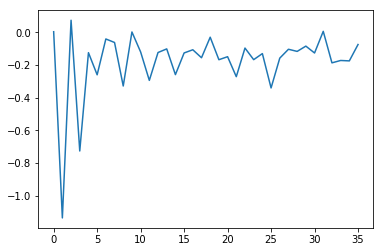

In [0]:
plt.plot(means)

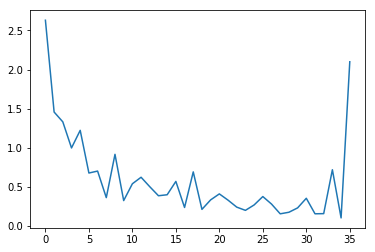

In [0]:
plt.plot(stds)

In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack_Sq,ActivationStats])
learn.fit_one_cycle(1)



0
0.6131209135055542
1.2771060466766357
0.8848843574523926
1.063057541847229
0.9698879718780518
1.0154048204421997
0.9923855066299438
1.0038292407989502
0.9980906844139099
1.0009560585021973
1
0.6577245593070984
1.2330421209335327
0.9005566835403442
1.0537667274475098
0.9741542935371399
1.0131789445877075
0.9934750199317932
1.0032784938812256
0.9983647465705872
1.0008186101913452
2
0.23798701167106628
2.049855947494507
0.6984548568725586
1.196549892425537
0.9141860604286194
1.0458821058273315
0.9778192639350891
1.0112782716751099
0.9944081902503967
1.0028076171875
0.9985991716384888
1.0007011890411377
3
1.0082587003707886
0.9958961009979248
1.0020582675933838
0.9989725351333618
1.000514030456543
4
0.19273202121257782
2.277839422225952
0.662580132484436
1.228515863418579
0.9022142291069031
1.0527981519699097
0.9746022820472717
1.0129460096359253
0.9935891032218933
1.003220796585083
0.9983935356140137
1.0008043050765991
5
1.3460478782653809
0.8619255423545837
1.077122688293457
0.96353483

epoch,train_loss,valid_loss,error_rate,time
0,0.734493,0.315022,0.100135,02:21


In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

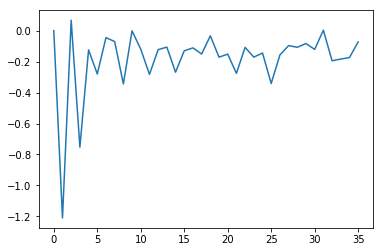

In [0]:
plt.plot(means)

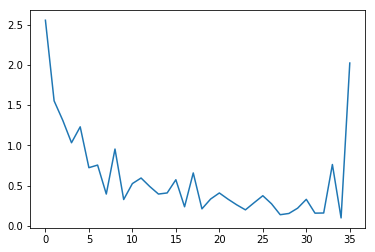

In [0]:
plt.plot(stds)

Pretrained = False

In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,pretrained=False)
learn.fit_one_cycle(5)



epoch,train_loss,valid_loss,error_rate,time
0,4.477866,3.783200,0.944520,02:12
1,4.217132,3.738859,0.924222,02:08
2,3.836927,3.765436,0.897158,02:20
3,3.464271,3.099820,0.842355,02:10
4,3.211449,2.912679,0.794317,02:10


In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=LSUV_HookCallBack_Sq,pretrained=False)
learn.fit_one_cycle(5)



0
0.20354431867599487
0.9999999403953552
1
1.0862829685211182
0.9999999403953552
2
0.91098952293396
0.9999999403953552
3
2.0200233459472656
1.0
4
1.1859595775604248
1.0
5
2.1849796772003174
1.0
6
0.9368482828140259
0.9999998807907104
7
1.970059871673584
1.0
8
0.9851251840591431
1.0
9
1.7250924110412598
0.9999999403953552
10
1.112108826637268
1.0
11
0.9322288632392883
0.9999998807907104
12
1.641937255859375
1.0
13
0.9825705885887146
0.9999998211860657
14
2.2094435691833496
1.0
15
1.0278828144073486
0.9999999403953552
16
1.8405685424804688
1.0
17
1.0161983966827393
1.0
18
1.97809898853302
1.0
19
1.2425801753997803
0.9999999403953552
20
0.9189213514328003
0.9999999403953552
21
1.6487213373184204
0.9999999403953552
22
1.0834577083587646
0.9999999403953552
23
2.219040632247925
1.0000001192092896
24
0.9922202825546265
1.0000001192092896
25
2.511077642440796
0.9999999403953552
26
0.9113543629646301
1.0
27
2.6858971118927
0.9999998807907104
28
1.0238949060440063
0.9999998211860657
29
2.0682103

epoch,train_loss,valid_loss,error_rate,time
0,4.093897,3.466738,0.906631,02:23


In [0]:
#Every Epoch 


In [0]:

class LSUV_HookCallBack_EveryEpoch(HookCallback):

    def on_epoch_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_epoch_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

In [0]:

learn = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[LSUV_HookCallBack_EveryEpoch,ActivationStats])
learn.fit_one_cycle(5)



epoch,train_loss,valid_loss,error_rate,time
0,0.964804,0.390148,0.113667,02:36
1,0.796649,0.332890,0.100812,02:37
2,0.586971,0.290315,0.085250,02:41
3,0.424326,0.242987,0.078484,02:37
4,0.345541,0.228420,0.073748,02:36


0
0.503025233745575
1.0
1
1.0045722723007202
1.0
2
0.3063422739505768
1.0
3
1.0149339437484741
0.9999998807907104
4
0.23118238151073456
1.0
5
0.9514177441596985
1.0
6
0.1570560336112976
0.9999999403953552
7
0.8835361003875732
1.0
8
0.26204895973205566
0.9999999403953552
9
0.42115262150764465
1.0
10
0.6988182067871094
1.0
11
0.16322781145572662
0.9999999403953552
12
0.5504027605056763
1.0000001192092896
13
0.11726640164852142
1.0
14
0.5784115195274353
1.0000001192092896
15
0.08472448587417603
1.0
16
0.640777051448822
1.0
17
0.2927694022655487
1.0
18
0.21526311337947845
1.0
19
0.5761858224868774
0.9999999403953552
20
0.1214173287153244
1.0
21
0.4713602662086487
0.9999998807907104
22
0.07754414528608322
1.0
23
0.4747708737850189
1.0
24
0.06810580939054489
1.0
25
0.4790875017642975
0.9999998807907104
26
0.05842622369527817
0.9999998807907104
27
0.48879554867744446
0.9999997615814209
28
0.07626381516456604
1.0000001192092896
29
0.44661471247673035
0.9999998807907104
30
0.12127389758825302
0

In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

In [0]:
means_ = [learn_.activation_stats.stats[0][i].mean() for i in range(36)]
stds_ = [learn_.activation_stats.stats[1][i].mean() for i in range(36)]

In [0]:
learn_.activation_stats.stats.shape

torch.Size([2, 36, 1845])

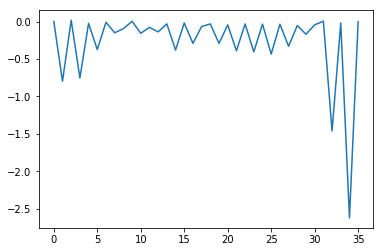

In [0]:
plt.plot(means_)

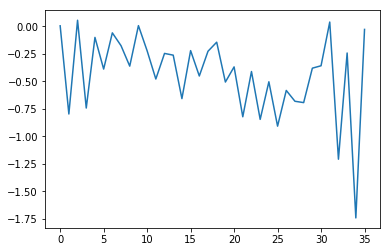

In [0]:
plt.plot(means)

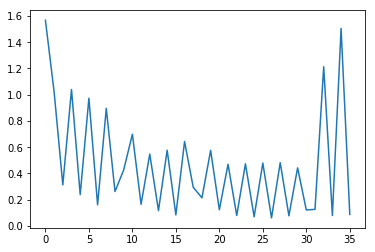

In [0]:
plt.plot(stds_)

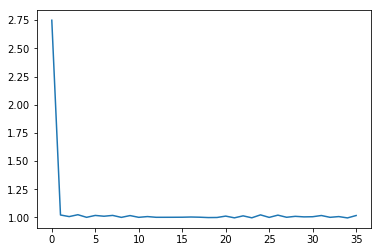

In [0]:
plt.plot(stds)

In [0]:
len(stds)

36

In [0]:
learn_ = cnn_learner(data, models.resnet34, metrics=error_rate,callback_fns=[ActivationStats])
learn_.fit_one_cycle(5)


epoch,train_loss,valid_loss,error_rate,time
0,0.882899,0.396769,0.143437,02:26
1,0.863867,0.373966,0.114344,02:16
2,0.681208,0.303889,0.093369,02:16
3,0.394812,0.263733,0.073748,02:16
4,0.363225,0.249747,0.070365,02:20


In [0]:
h = Hook(mod, append_stat)
xb = xb.cuda()



In [0]:
_y = learn.model(xb)

TypeError: ignored

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 79.1MB/s]


RuntimeError: ignored

In [0]:
type(learn.activation_stats)

NameError: ignored

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 

In [0]:
learn.activation_stats.stats.shape


torch.Size([2, 36, 369])

In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

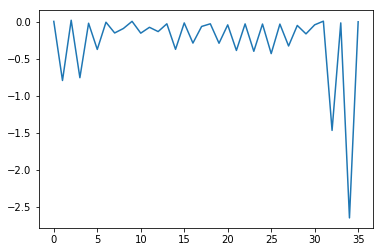

In [0]:
plt.plot(means)

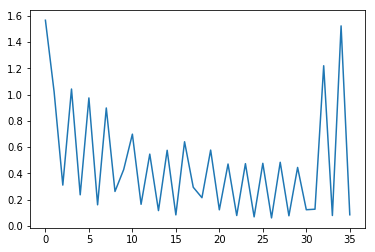

In [0]:
plt.plot(stds)

In [0]:
mean_problem = [learn.activation_stats.stats[0][i].mean() for i in range(30,36)]

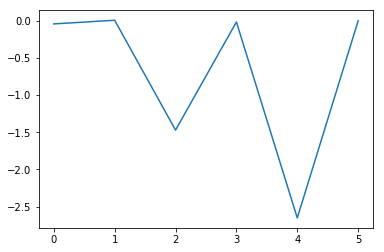

In [0]:
plt.plot(mean_problem)

In [0]:
learn.activation_stats.stats[0][34]

tensor([-2.6417, -2.6649, -2.6384, -2.6694, -2.6948, -2.6785, -2.6846, -2.6154,
        -2.6500, -2.6479, -2.6621, -2.6590, -2.6610, -2.6589, -2.6723, -2.6632,
        -2.6850, -2.6750, -2.6401, -2.6907, -2.6548, -2.6438, -2.6953, -2.6502,
        -2.6788, -2.6268, -2.6012, -2.6430, -2.6665, -2.6510, -2.6591, -2.7065,
        -2.6801, -2.6328, -2.6517, -2.6700, -2.6834, -2.6607, -2.6451, -2.6641,
        -2.6797, -2.6389, -2.6563, -2.6543, -2.6783, -2.6831, -2.6409, -2.6605,
        -2.6672, -2.6558, -2.6590, -2.6328, -2.7044, -2.6608, -2.6725, -2.6525,
        -2.6387, -2.6622, -2.6777, -2.6944, -2.6566, -2.6634, -2.6479, -2.6470,
        -2.6460, -2.6681, -2.6781, -2.6628, -2.6677, -2.6234, -2.6744, -2.6465,
        -2.6563, -2.6768, -2.6613, -2.6632, -2.6440, -2.6333, -2.6654, -2.6504,
        -2.6410, -2.6842, -2.6299, -2.6423, -2.6698, -2.6901, -2.6503, -2.6609,
        -2.6756, -2.6713, -2.6805, -2.6459, -2.6671, -2.6653, -2.6437, -2.6352,
        -2.6671, -2.6642, -2.6563, -2.61

In [0]:
from fastai.text import *

In [0]:
from fastai.callbacks import Hooks

In [0]:
import os 

In [0]:
import warnings

In [0]:
warnings.filterwarnings("ignore")


In [0]:
bs=48
path = untar_data(URLs.IMDB)
path.ls()





[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

In [0]:
path

PosixPath('/root/.fastai/data/imdb')

In [0]:

data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


In [0]:
learn_lm.save_encoder('fine_tuned_enc')


In [0]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
from fastai.callbacks import HookCallback
from torch.nn import LSTM

In [0]:
class  Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
        "Applies `hook_func` to `module`, `input`, `output`."
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()
        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()

class Hooks():
    "Create several hooks on the modules in `ms` with `hook_func`."
    def __init__(self, ms:Collection[nn.Module], hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int)->Hook: return self.hooks[i]
    def __len__(self)->int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        "Remove the hooks from the model."
        for h in self.hooks: h.remove()

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()


In [0]:
class Hook():
    "Create a hook on `m` with `hook_func`."
    def __init__(self, m, hook_func, is_forward=True, detach=True):
        self.hook_func,self.detach,self.stored = hook_func,detach,None
        f = m.register_forward_hook if is_forward else m.register_backward_hook
        self.hook = f(self.hook_fn)
        self.removed = False

    def hook_fn(self, module, input, output):
        "Applies `hook_func` to `module`, `input`, `output`."
        import pdb;pdb.set_trace()
        if self.detach:
            input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
            output = (o.detach() for o in output) if is_listy(output) else output.detach()

        self.stored = self.hook_func(module, input, output)

    def remove(self):
        "Remove the hook from the model."
        if not self.removed:
            self.hook.remove()
            self.removed=True

    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()


class Hooks():
    "Create several hooks on the modules in `ms` with `hook_func`."
    def __init__(self, ms, hook_func, is_forward=True, detach=True):
        self.hooks = [Hook(m, hook_func, is_forward, detach) for m in ms]

    def __getitem__(self,i:int)->Hook: return self.hooks[i]
    def __len__(self)->int: return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    @property
    def stored(self): return [o.stored for o in self]

    def remove(self):
        "Remove the hooks from the model."
        for h in self.hooks: h.remove()

    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()


In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, torch.nn.LSTM)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()


class ActivationStats_LSTM(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m, i, o):
        "Take the mean and std of `o`."
        import pdb;pdb.set_trace()
        return o[1][0].mean().item(),o[1][0].std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m:nn.Module, i:tuple, o:tuple)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()

In [0]:
gc.collect()

133

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,callback_fns=ActivationStats_LSTM)


In [0]:
mean = []
std = []
def hook(m, i, o):
    "Take the mean and std of `o`."
    mean.append(o[1][0].mean().item())
    std.append(o[1][0].std().item())


In [0]:
learn = learn.load_encoder('fine_tuned_enc')


In [0]:
modules = [m for m in flatten_model(learn.model)
                            if isinstance(m, torch.nn.LSTM)]


In [0]:
modules[0].register_forward_hook(hook)

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
len(mean)

0

In [0]:
means = [learn.activation_stats.stats[0][i].mean() for i in range(36)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(36)]

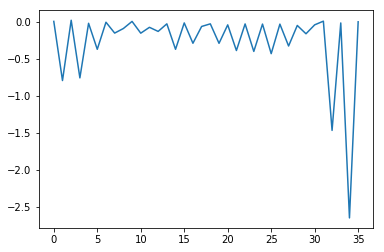

In [0]:
plt.plot(means)

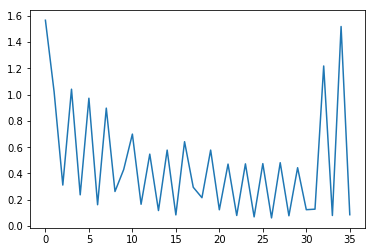

In [0]:
plt.plot(stds)

In [0]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

In [0]:
mods[0].num_layers

1

In [0]:

def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.to(torch.device('cuda'))


In [0]:
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

In [0]:
xb,yb = data_clas.one_batch()

In [0]:
data_clas.train_dl.x.to(torch.device('cuda'))

AttributeError: ignored

In [0]:
for hook in hooks: print(hook.mean,hook.std)

In [0]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

In [0]:
mdl

In [0]:
>>> rnn = nn.LSTM(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)

In [0]:
rnn.register_forward_hook(hook)


In [0]:
>>> output, (hn, cn) = rnn(input, (h0, c0))


> <ipython-input-114-90662714e63a>(4)hook()
-> return o.mean().item(),o.std().item()
(Pdb) o 
(tensor([[[-2.5948e-01, -8.9714e-02, -3.8792e-01, -1.2304e-01, -2.9241e-01,
          -4.2353e-01, -5.5217e-02,  2.7919e-01,  5.0661e-01,  7.4136e-02,
           3.4006e-02, -3.3203e-02, -7.0854e-02,  2.9344e-01,  1.4524e-01,
          -5.5786e-01,  8.9902e-02,  3.1441e-02,  6.4520e-02, -1.6160e-01],
         [-3.2259e-01,  9.8162e-02, -3.0071e-01,  1.1216e-01, -1.7026e-01,
           1.1765e-01,  1.2366e-01, -2.1583e-01, -5.0714e-01,  5.6318e-01,
           1.7843e-01,  1.4180e-01, -1.9182e-01, -6.0614e-04, -1.7267e-01,
          -5.3232e-01,  1.8171e-02,  3.6531e-01, -1.7608e-01, -5.5089e-01],
         [ 3.3725e-02,  3.2056e-01,  6.3262e-01, -1.3860e-02, -3.8328e-01,
          -2.0100e-01, -2.2671e-01,  2.6368e-01,  3.9997e-02,  1.7674e-01,
          -1.4727e-01,  5.0521e-02, -4.0556e-01,  4.1815e-02,  2.0404e-01,
          -1.7777e-01, -2.4711e-01,  9.4845e-02, -5.0206e-01, -1.8404e-01]],



BdbQuit: ignored

Testing Out Activation Stats With Vision. 



Experimenting with Entanglement and Soft Nearest Neighbor Loss